In [2]:
%matplotlib inline

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as mcc_fn
from sklearn.metrics import accuracy_score as acc_fn

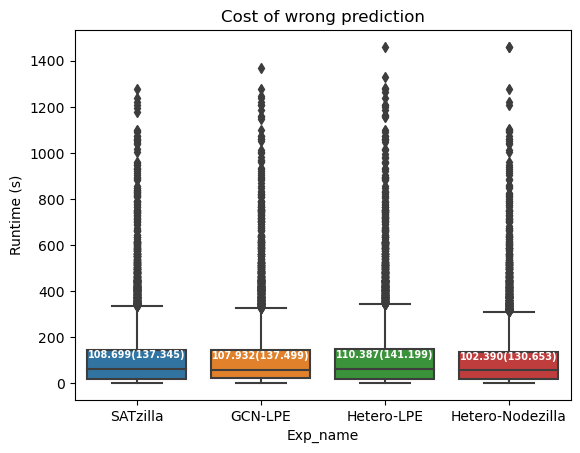

In [13]:
# Plot 
num_classes = 7
split_idx = 0
seed = 604

exp_dirs = {
    'SATzilla': "/home/vincent/sat/sat_selection_light/lightning_logs/0604_satzilla_mlp",   # Raw logs in baselines/ directory
    'GCN-LPE': "/home/vincent/sat/sat_selection_light/lightning_logs/0608_solv-none",
    'Hetero-LPE': "/home/vincent/sat/sat_selection_light/lightning_logs/0802_hetero_logits",
    'Hetero-Nodezilla': "/home/vincent/sat/sat_selection_light/lightning_logs/0808_hetero_satzilla_feat"
}

res = {}

for exp_name, exp_dir in exp_dirs.items():
    run_dir = os.path.join(exp_dir, f"seed_{seed}_split_{split_idx}")
    pred_filepath = os.path.join(run_dir, 'test_pred_probs.csv')
    label_filepath = os.path.join(run_dir, 'test_labels.csv')

    if not os.path.isfile(pred_filepath):
        continue

    preds = pd.read_csv(pred_filepath, index_col=False).to_numpy()
    # Note that the labels saved in sat_selection_light has variables other than runtime
    labels = pd.read_csv(label_filepath, index_col=False).to_numpy()
    if labels.shape[1] == 10:
        runtime = labels[:, 2:-1]

    if num_classes == 5:   # Remove kissat3 and bulky
        runtime = np.concatenate([labels[:, 1:5], labels[:, 6:]], axis=-1)

    pred_idx =  preds.argmax(axis=1)
    tgt_idx = runtime.argmin(axis=1)

    len_data = preds.shape[0]
    pred_rt = runtime[torch.arange(len_data), pred_idx] 
    tgt_rt = runtime.min(axis=1)

    rt_delta = pred_rt - tgt_rt

    rt_delta_cost = rt_delta[rt_delta>0]
    # cost_mean = rt_delta_cost.mean()
    # cost_std = rt_delta_cost.std()

    res[exp_name] = rt_delta_cost

plt.figure()
exp_names = list(res.keys())
values = list(res.values())
ax = sns.boxplot(values)
ax.set_xticklabels(exp_names)

means = [v.mean() for v in values]
stds = [v.std() for v in values]
for xtick in ax.get_xticks():
    ax.text(xtick, means[xtick],f"{means[xtick]:.3f}({stds[xtick]:.3f})", 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

plt.title(f"Cost of wrong prediction")
plt.xlabel('Exp_name')
plt.ylabel('Runtime (s)')
# plot_savepath = pred_filepath.split('.')[0]+'.png' 
# plt.savefig(plot_savepath)
plt.show()
plt.close()
